In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

# Define the Flow class as given
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64, auton: bool = False):
        super().__init__()
        self.auton = auton
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )

    def forward(self, t: torch.Tensor, x_t: torch.Tensor) -> torch.Tensor:
        if self.auton:
            t = torch.zeros_like(t) # Autonomous
        return self.net(torch.cat((t, x_t), dim=-1))

    def step(self, x_t: torch.Tensor, t_start: torch.Tensor, t_end: torch.Tensor) -> torch.Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        mid_t = t_start + (t_end - t_start) / 2
        mid_x = x_t + self(t=t_start, x_t=x_t) * (t_end - t_start) / 2
        return x_t + (t_end - t_start) * self(t=mid_t, x_t=mid_x)

# Hyperparameters
flow_dims = 28 * 28  # Flattened MNIST images are 784-dimensional
h = 64 #256
lr = 5e-3
batch_size = 256
betas = (0.9, 0.999)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./mnist_data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Using device cuda


In [2]:
from scipy.optimize import linear_sum_assignment

# Instantiate the model and optimizer
flow = Flow(dim=flow_dims, h=h, auton=False).to(device)
optimizer = torch.optim.AdamW(flow.parameters(), lr=lr, betas=betas)
loss_fn = nn.MSELoss()

# Show number of parameters
num_params = sum(p.numel() for p in flow.parameters())
print(f'Number of parameters: {num_params}')

# We’ll define num_epochs based on iterations and dataset size
num_iterations = 10000
dataset_size = len(train_dataset)
num_batches_per_epoch = dataset_size // batch_size
num_epochs = num_iterations // num_batches_per_epoch

pbar = tqdm(total=num_iterations, desc="Training Progress")
losses = []

flow.train()
for epoch in range(num_epochs):
    for (images, _) in train_loader:
        # Flatten MNIST images from [batch, 1, 28, 28] to [batch, 784]
        x_1_batch = images.view(images.size(0), -1).to(device)

        # Sample from Gaussian for x_0
        x_0_batch = torch.randn_like(x_1_batch).to(device)  # shape: [batch, 784]

        # ---- OT Step: Find optimal match between x_0_batch and x_1_batch ----
        # Compute cost matrix (squared Euclidean distance)
        # x_0_batch: shape [B, D], x_1_batch: shape [B, D]
        with torch.no_grad():
            # Expand and compute pairwise cost
            x0_expanded = x_0_batch.unsqueeze(1)  # [B,1,D]
            x1_expanded = x_1_batch.unsqueeze(0)  # [1,B,D]
            diff = x0_expanded - x1_expanded       # [B,B,D]
            cost_matrix = torch.sum(diff**2, dim=2).cpu().numpy()  # [B,B]

        # Solve assignment problem for minimal cost matching
        row_idx, col_idx = linear_sum_assignment(cost_matrix)

        # Reorder x_1_batch according to OT solution
        x_1_matched = x_1_batch[col_idx]

        # Now (x_0_batch[i], x_1_matched[i]) is an OT pair
        # ---------------------------------------------------------------------
        
        # Sample random t in [0,1]
        t = torch.rand(len(x_1_matched), 1).to(device)
        
        # Compute x_t and dx_t
        x_t = (1 - t) * x_0_batch + t * x_1_matched
        dx_t = x_1_matched - x_0_batch

        # Forward pass
        optimizer.zero_grad()
        out = flow(t=t, x_t=x_t)

        # Compute loss
        cur_loss = loss_fn(out, dx_t)
        cur_loss.backward()
        optimizer.step()

        losses.append(cur_loss.item())
        pbar.set_postfix({'loss': cur_loss.item()})
        pbar.update(1)
pbar.close()


Number of parameters: 109584


Training Progress:   8%|▊         | 847/10000 [01:06<12:06, 12.60it/s, loss=1.07]

KeyboardInterrupt: 

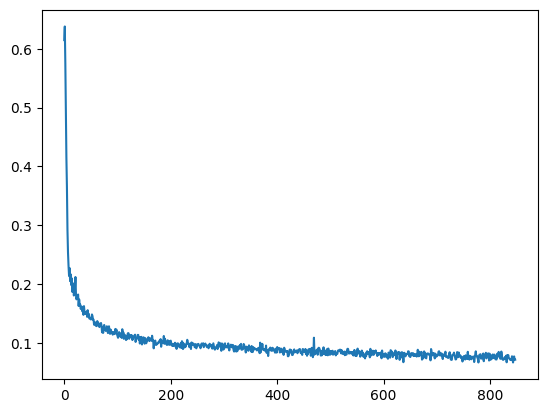

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.log(losses))
plt.show()
plt.close()

(4, 16, 784)


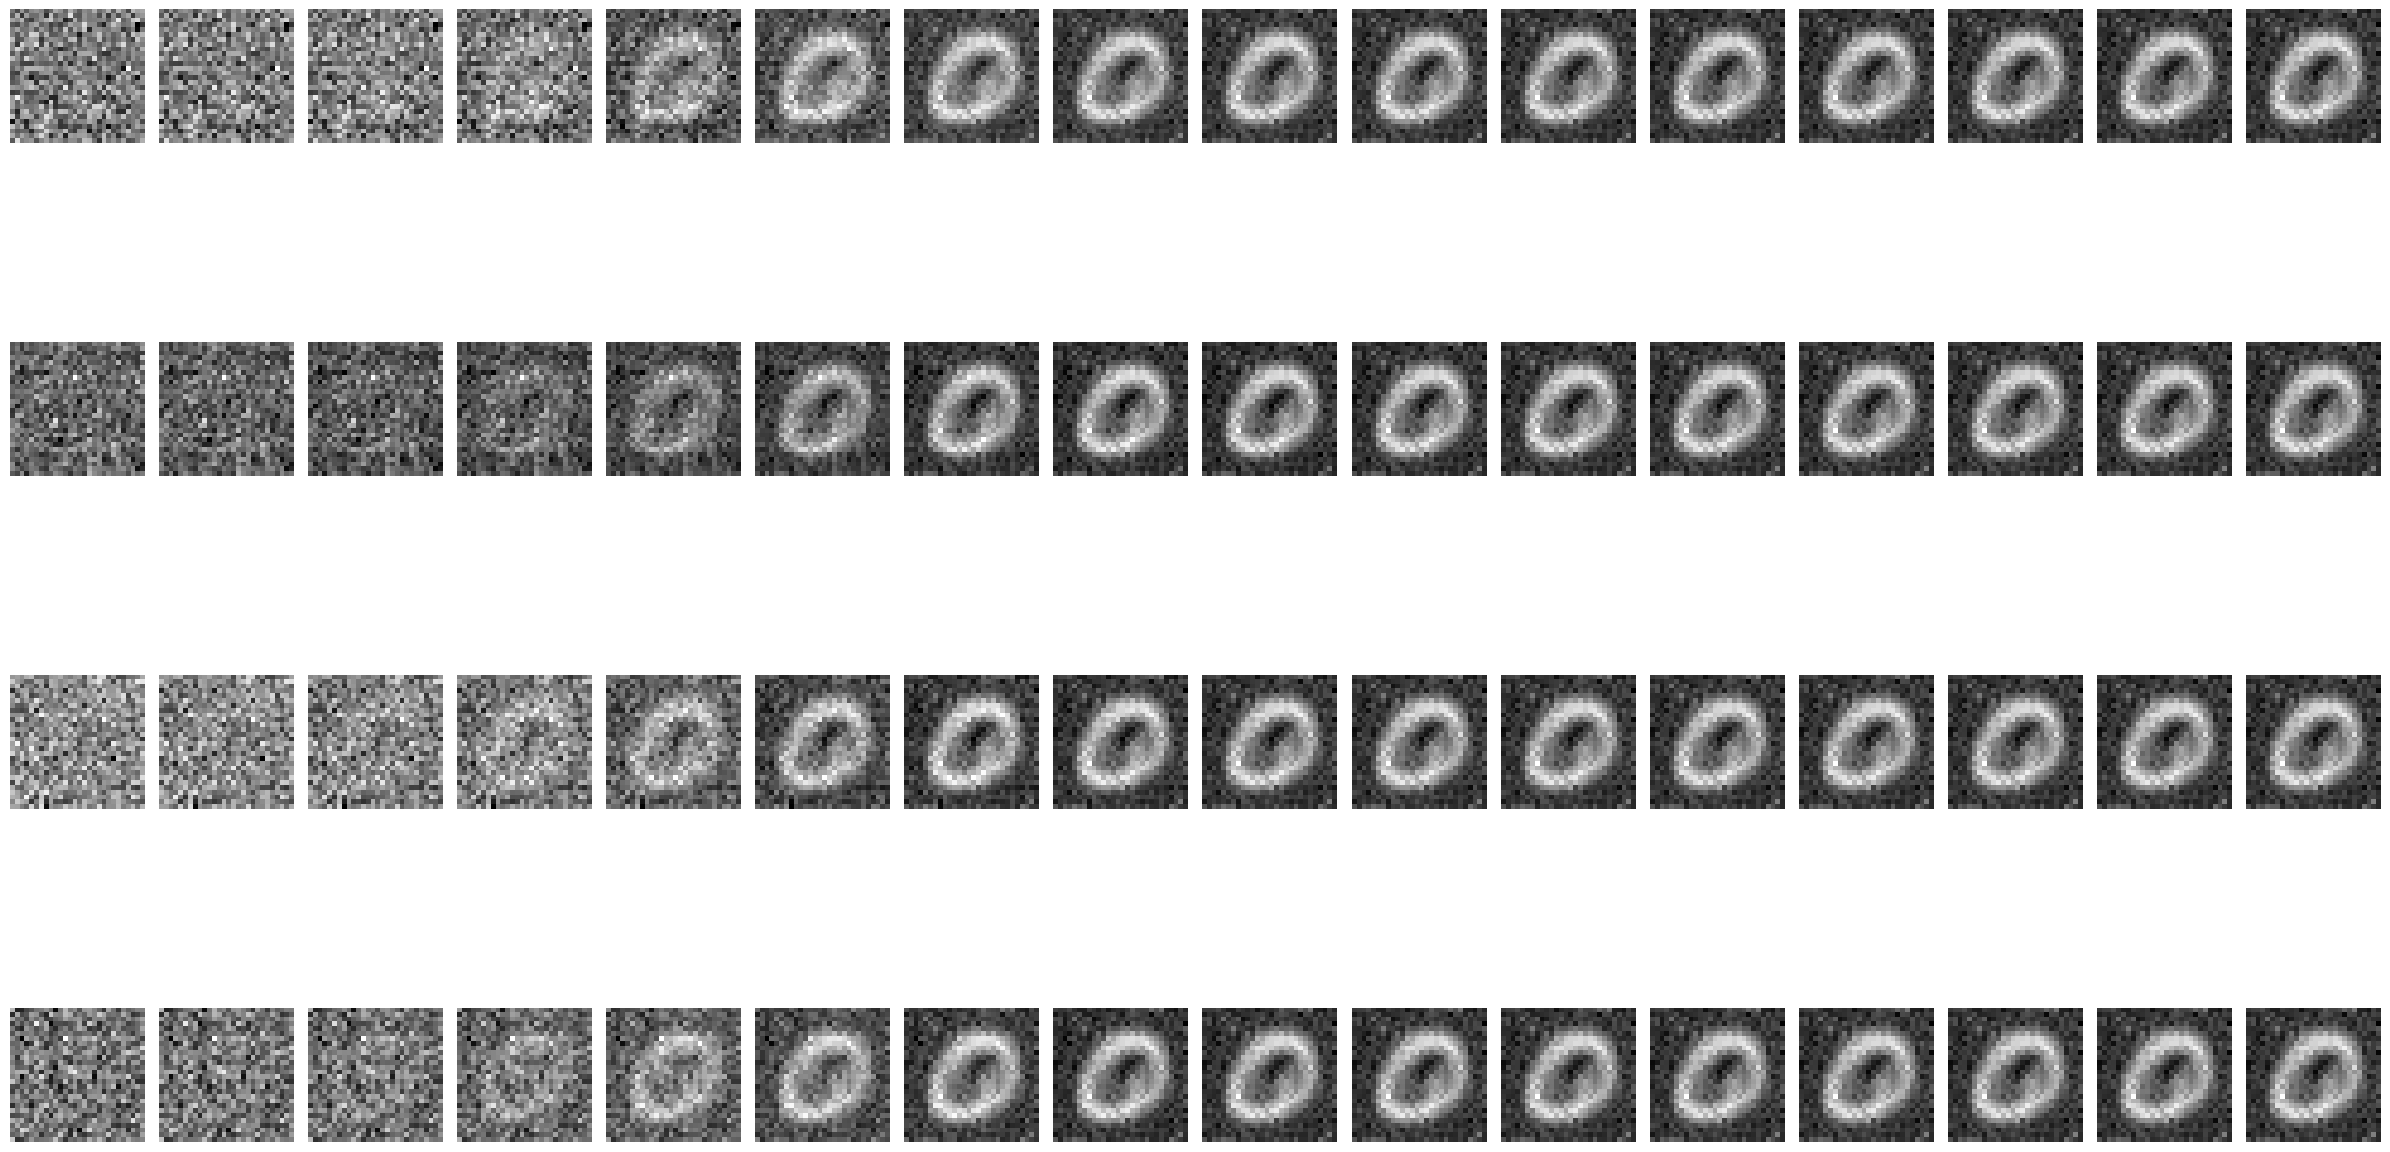

Training Progress:   8%|▊         | 848/10000 [01:20<12:06, 12.60it/s, loss=1.07]

In [ ]:
# Generate
# Plot trajectories from 0 to 1.0 using red lines
n_steps = 16
n_trajs = 4
x = torch.randn(n_trajs, flow_dims)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

# Obtain the trajectories
flows = []
for i in range(n_steps):
    x = flow.step(x_t=x.to(device), t_start=time_steps[i].to(device), t_end=time_steps[i + 1].to(device)).to("cpu")
    x = x*0.5 + 0.5
    flows.append(x)
flows = torch.stack(flows, dim=1)
flows = flows.detach().numpy()
print(flows.shape)

fig, axs = plt.subplots(n_trajs, n_steps, figsize=(n_steps*1.5, 15))
for traj in range(n_trajs):
    for i in range(n_steps):
        axs[traj, i].imshow(flows[traj, i, :].reshape(28, 28), cmap='gray')
        axs[traj, i].axis('off')
plt.tight_layout()
plt.show()
plt.close()
